In [1]:
import torch
import torchvision.datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch import nn
import numpy as np

from torchsummary import summary

import matplotlib.pyplot as plt

## Datasets

In [2]:
mnist_dataset = torchvision.datasets.MNIST(
    root="Mnist_dataset",
    download=True,
    train=True,
    transform=ToTensor()
)

train,val,test = torch.utils.data.random_split(mnist_dataset,(0.8,0.1,0.1))

batch_size = 500
train_loader = DataLoader(
    dataset=train,
    shuffle=True,
    batch_size=batch_size
)

val_loader = DataLoader(
    dataset=val,
    shuffle=True,
    batch_size=batch_size
)

## VAE Encoder
Similar to standard Autoencoder, but with two independent lineal layer to represent mean and logvar


In [3]:
def Conv_block(in_channels,out_channels, kernel_size = 4, stride = 2, padding = 1):
    return nn.Sequential(
        nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
        ),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )

class Encoder(nn.Module):
    def __init__(self, in_channels:int , latent_dims:int):
        super().__init__()
        self.convolutions = nn.Sequential(
            Conv_block(in_channels,128),
            Conv_block(128,256),
            Conv_block(256,512),
            Conv_block(512,1024)
        )

        self.mu = nn.Linear(1024,latent_dims)
        self.logvar = nn.Linear(1024,latent_dims)

    def forward(self, x:torch.Tensor):
        bs = x.shape[0]
        # print(x.shape)

        x = self.convolutions(x)
        x = x.reshape(bs,-1)
        # x = x.flatten(start_dim=1)
        mu = self.mu(x)
        logvar = self.logvar(x)

        return mu,logvar
        # return x

In [ ]:
# VAE_encoder = Encoder(in_channels=1,latent_dims=2).cuda()

# # VAE_encoder(a.cuda()).shape

# summary(VAE_encoder, (1,28,28), batch_size=100)

## Decoder
Similar to standard decoder, but take a data from distribution defined by encoder.
Actually, we don't need to make non changes. 

In [4]:
def conv_transpose_block(
        in_channels,
        out_channels,
        kernel_size=3,
        stride=2,
        padding=1,
        output_padding=0,
        with_act=True
):
    modules = [
        nn.ConvTranspose2d(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            output_padding=output_padding
            )   
    ]

    if with_act:
        modules.append(nn.BatchNorm2d(out_channels))
        modules.append(nn.ReLU())

    return nn.Sequential(*modules)


class Decoder(nn.Module):
    def __init__(self,out_channels:int , latent_dims:int):
        super().__init__()

        self.lineal = nn.Linear(latent_dims,1024*4*4)
        self.t_conv = nn.Sequential(
            conv_transpose_block(1024,512),
            conv_transpose_block(512,256,output_padding=1),
            conv_transpose_block(256,out_channels,output_padding=1,with_act=False)
        )

    def forward(self, x:torch.Tensor):
        bs = x.shape[0]

        x = self.lineal(x)
        x = x.reshape((bs,1024,4,4))
        x = self.t_conv(x)
        
        return x

## Variational Autoencoder

In [5]:
class VAE_AutoEncoder(nn.Module):
    def __init__(self, in_channels, latent_dims:int):
        super().__init__()
        self.encoder = Encoder(in_channels,latent_dims)
        self.decoder = Decoder(in_channels,latent_dims)

    def encode(self,x):
        return self.encoder(x)

    def decode(self,z):
        return self.decoder(z)


    def forward(self,x):
        mu,logvar = self.encode(x)
        
        #Take a sample from distribution
        std = torch.exp(0.5*logvar) # Compute standard desviation
        z = self.sample(mu,std)
        
        reconstructed = self.decode(z)

        # Return reconstructed image and, mean and logvar to calculate losses
        return reconstructed, mu, logvar



    def sample(self,mu,std):
        standard_sample = torch.randn_like(std)

        return mu + (standard_sample * std) # Take a sample of standarized distribution and transforming it to mean and desviation given
                                            # This method is used to simplify gradient calculus

In [6]:
n_latent_dims = 10
VAE_model = VAE_AutoEncoder(in_channels=1,latent_dims=n_latent_dims).cuda()
summary(VAE_model,(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 14, 14]           2,176
       BatchNorm2d-2          [-1, 128, 14, 14]             256
              ReLU-3          [-1, 128, 14, 14]               0
            Conv2d-4            [-1, 256, 7, 7]         524,544
       BatchNorm2d-5            [-1, 256, 7, 7]             512
              ReLU-6            [-1, 256, 7, 7]               0
            Conv2d-7            [-1, 512, 3, 3]       2,097,664
       BatchNorm2d-8            [-1, 512, 3, 3]           1,024
              ReLU-9            [-1, 512, 3, 3]               0
           Conv2d-10           [-1, 1024, 1, 1]       8,389,632
      BatchNorm2d-11           [-1, 1024, 1, 1]           2,048
             ReLU-12           [-1, 1024, 1, 1]               0
           Linear-13                   [-1, 10]          10,250
           Linear-14                   

## Training VAE
We create a new loss from combitanion of two losses:
* The old one, from recreated images
* A new from logvar: *Kullback–Leibler divergence* (KLD) is a functions that compares a distribution from another one, in this case, the standard

This combination is a sum of boths

In some cases, we can put more weigth on one of the lossesx, to balance the reconstruction of gaussian distribution.


In [7]:
import torch.nn.functional as F
def vae_loss(batch, reconstructed_image, mu, logvar):
    bs = batch.shape[0]


    reconstruction_loss = F.mse_loss(
        reconstructed_image.reshape(bs, -1),
        batch.reshape(bs,-1),
        reduction="none"
    ).sum(dim=-1)

    KL_loss = -0.5* torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=-1)

    loss = (reconstruction_loss + KL_loss).mean(dim=0)

    return (loss, reconstruction_loss, KL_loss)


In [8]:
def train_loop(loader:torch.utils.data.DataLoader, model : nn.Module, optimizer:torch.optim, loss_fn:callable):
    nlotes = len(loader)
    # train_size = len(loader.dataset)

    model.train()   #Preparo el modelo para el entrenamiento

    losses = {
        "loss": [],
        "reconstruction_loss": [],
        "KL_loss": []
    }

    train_losses = 0

    # losses_list = []

    for nlote,(x,_) in enumerate(loader):
        x = x.cuda()

        # Forward Pass
        reconstructed ,mu ,logvar = model(x)

        # Backpropagation
        loss,reconstruction_loss,KL_loss = loss_fn(x, reconstructed, mu, logvar)    #Calculo de loss
        
        loss.backward()             #Calculo de gradiente
        
        # Save Losses
        losses["loss"].append(
            loss.item())
        losses["reconstruction_loss"].append(
            reconstruction_loss.mean().item()
        )
        losses["KL_loss"].append(
            KL_loss.mean().item()
        )

        optimizer.step()            #Actualización de parámetros
        optimizer.zero_grad()       #Limpieza del optimizador

        #Guardamos algunas caractgerísticas para plotear al final
        train_losses += loss.item()

        #Muestra del proceso
        if nlote % 10 == 0:
            print("Nº de lote:\t",nlote)
            print("Loss:\t\t\t",loss.item())
            print("Reconstruction_loss:\t",reconstruction_loss.mean().item())
            print("KL_loss:\t\t",KL_loss.mean().item())
            print()

    train_losses /= nlotes
    print()
    print("\tAccuracy/Loss Promedio")
    # print(f"\t\tEntrenamiento: {(100*train_accuracy):>0.1f}% / {train_losses:>8f}")
    print(f"\t\tEntrenamiento: {train_losses:>8f}")

    return losses

In [9]:
def val_loop(loader:torch.utils.data.DataLoader, model:nn.Module, loss_fn:callable):
    
    # val_size = len(loader.dataset)
    nlotes = len(loader)

    model.eval()         #Preparo el modelo para inferencia

    val_losses = 0
    losses_list = []

    with torch.inference_mode():       #Calcelo el calculo del gradiente
        for x,_ in loader:
            
            x = x.cuda()
            recosntructed, mu, logvar = model(x)       # Inferencia
            
            loss,_,_ = loss_fn(x, recosntructed, mu, logvar)

            val_losses += loss.item()
            losses_list.append(loss.item())

    val_losses /= nlotes

    print(f"\t\t Validación: {val_losses:>8f}")

    return losses_list


In [10]:
epochs = 10
lr = 0.0001

optimizer = torch.optim.AdamW(VAE_model.parameters(),lr=lr,eps=1e-5)

In [11]:
training_losses = {
        "loss": [],
        "reconstruction_loss": [],
        "KL_loss": []
    }
val_losses = []


for epoch in range(epochs):
    print(f"Itenración: {(epoch + 1)} / {epochs} -----------------------------")
    
    #Train
    output_output = train_loop(train_loader,VAE_model,optimizer,vae_loss)
    training_losses["loss"]                 += output_output["loss"]
    training_losses["reconstruction_loss"]  += output_output["reconstruction_loss"]
    training_losses["KL_loss"]              += output_output["KL_loss"]
    
    #Validation
    val_output = val_loop(val_loader,VAE_model,vae_loss)
    val_losses += val_output

print("Finalizado entrenamiento del modelo!")
# output_losses = train_loop(train_loader,VAE_model,optimizer,vae_loss)

Itenración: 1 / 10 -----------------------------
Nº de lote:	 0
Loss:			 7421.45458984375
Reconstruction_loss:	 7420.35791015625
KL_loss:		 1.0969175100326538

Nº de lote:	 10
Loss:			 1403.3873291015625
Reconstruction_loss:	 1313.1837158203125
KL_loss:		 90.20361328125

Nº de lote:	 20
Loss:			 524.6278076171875
Reconstruction_loss:	 482.0098876953125
KL_loss:		 42.617916107177734

Nº de lote:	 30
Loss:			 328.95611572265625
Reconstruction_loss:	 291.4952087402344
KL_loss:		 37.460906982421875

Nº de lote:	 40
Loss:			 208.23097229003906
Reconstruction_loss:	 181.65200805664062
KL_loss:		 26.57895851135254

Nº de lote:	 50
Loss:			 132.19288635253906
Reconstruction_loss:	 102.29397583007812
KL_loss:		 29.898897171020508

Nº de lote:	 60
Loss:			 125.32896423339844
Reconstruction_loss:	 106.02686309814453
KL_loss:		 19.302108764648438

Nº de lote:	 70
Loss:			 109.79420471191406
Reconstruction_loss:	 89.04364776611328
KL_loss:		 20.750572204589844

Nº de lote:	 80
Loss:			 96.874488830

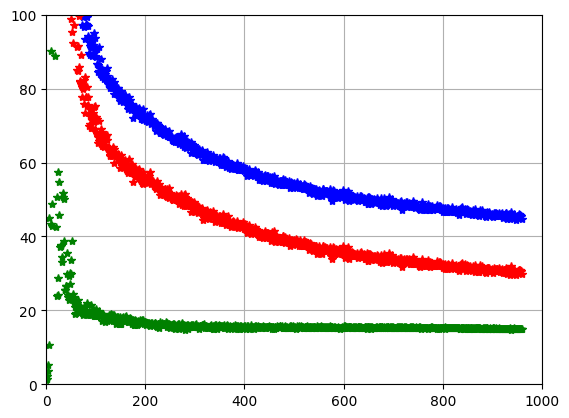

In [13]:
fig = plt.figure()
plt.plot(range(len(training_losses["loss"])),training_losses["loss"],"b*")
plt.plot(range(len(training_losses["reconstruction_loss"])),training_losses["reconstruction_loss"],"r*")
plt.plot(range(len(training_losses["KL_loss"])),training_losses["KL_loss"],"g*")
plt.axis((0,1000,0,100),)
plt.grid()

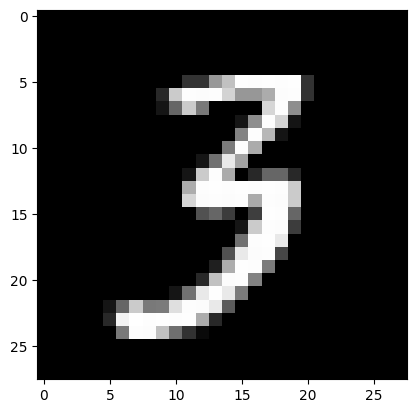

In [14]:
steps = len(train)

img = test[torch.randint(len(test),(1,))][0].unsqueeze(0).cuda()

VAE_model.eval()
with torch.inference_mode():
    reconstructed_img = VAE_model(img)[0]
plt.imshow(img.cpu().squeeze(),cmap="grey");

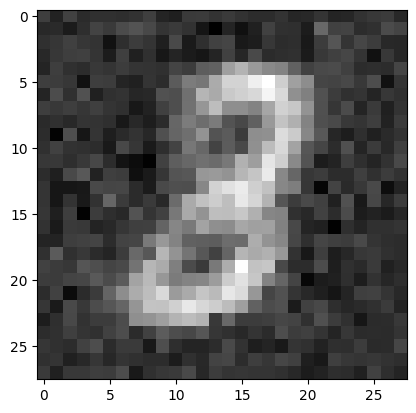

In [15]:
plt.imshow(reconstructed_img.cpu().detach().squeeze(),cmap="grey");

## Latent Space Representation
The latent space that the VAE create should be more structurated.
We expect that the representation of the numbers to follow an gaussian distribution on this space, making easy to generate new data from space points.

In [16]:
test_output = {
    0:[[] for _ in range(n_latent_dims)],
    1:[[] for _ in range(n_latent_dims)],
    2:[[] for _ in range(n_latent_dims)],
    3:[[] for _ in range(n_latent_dims)],
    4:[[] for _ in range(n_latent_dims)],
    5:[[] for _ in range(n_latent_dims)],
    6:[[] for _ in range(n_latent_dims)],
    7:[[] for _ in range(n_latent_dims)],
    8:[[] for _ in range(n_latent_dims)],
    9:[[] for _ in range(n_latent_dims)]
}

low_limits  = [10000 for _ in range(n_latent_dims)]
up_limits   = [-10000 for _ in range(n_latent_dims)]

VAE_model.eval()
for img,lbl in test:

    # lbls_list.append(lbl)

    with torch.inference_mode():
        mu_output = VAE_model.encode(img.cuda().unsqueeze(1))[0]   #We only need the mu value
    
    mu = mu_output[0].cpu().tolist()

    for idx in range(n_latent_dims):
        test_output[lbl][idx].append(mu[idx])

        if mu[idx] > up_limits[idx]:
            up_limits[idx] = mu[idx]

        if mu[idx] < low_limits[idx]:
            low_limits[idx] = mu[idx]

In [ ]:
plt.Figure(figsize=(10,8))
for key in test_output.keys():
    plt.scatter(test_output[key][2],test_output[key][6],label=key);
plt.legend();

### Line on the latent space

In [ ]:
y = -0.4
x_range = torch.arange(-4,3.5,0.5)
z = torch.empty((len(x_range),2))
for idx,x in enumerate(x_range):
    z[-idx-1] = torch.tensor([y,x.item()])

new_data = VAE_model.decode(z.cuda())

### Certain random lane on n-dimension latent space
Take 2 random points on the latent space and make 30 intermediate points to reconstruct images.

In [24]:
n_dims = n_latent_dims
n_pts = 30

coords = np.empty((n_dims,2))

for dim in range(n_dims):   #Generate random points for every dimensions, with those boundaries
    coords[dim] = np.random.uniform(low=low_limits[dim],high=up_limits[dim],size=(2))

a = coords[:,0] #unite the random datgo on 2 n-dims points
b = coords[:,1]

z_array = np.linspace(a,b,n_pts)    #generate the intermediate points and trasform to Tensor.
z = torch.Tensor(z_array)

In [ ]:
z_array = np.linspace(up_limits,low_limits,n_pts)   #Take the max and min corners of the latent space. 
                                                    #This can be useful with large amount of dims
z = torch.Tensor(z_array)

In [25]:
VAE_model.eval()
with torch.inference_mode():
    new_data = VAE_model.decode(z.cuda())   #Generate images from random data.

In [26]:
img_list = []
for img in new_data:                    # Add images on a big tensor, one next to the other
    img_list.append(img.squeeze())
    # torch.cat((img_list,img.cpu()),dim=1)

img_array = torch.cat(img_list,dim=1)

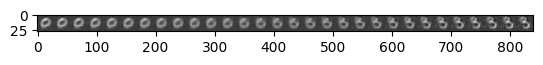

In [27]:
plt.imshow(img_array.cpu().detach(),cmap="grey");   #Plot of all the images.


### Export to .gif
Export the results to a .gif animation to visualize it

In [28]:
def normalizar_a_255_general(array_numpy):
    """
    Normaliza un array de NumPy a escala de grises (rango [0, 255], dtype uint8)
    detectando automáticamente los valores mínimo y máximo del array de entrada.

    Args:
        array_numpy: El array de NumPy de entrada.

    Returns:
        Un array de NumPy normalizado en el rango [0, 255] y tipo de dato uint8.
        Si todos los valores de entrada son iguales, devuelve un array lleno de 127 (gris medio).
    """
    min_valor = np.min(array_numpy) # Encontrar el valor mínimo en el array
    max_valor = np.max(array_numpy) # Encontrar el valor máximo en el array

    # Caso especial: Si el valor mínimo y máximo son iguales, evitar división por cero y devolver un array gris medio
    if max_valor == min_valor:
        return np.full_like(array_numpy, 127, dtype=np.uint8) # Devolver array lleno de gris medio (valor 127)

    # Normalización general: Mapear el rango [min_valor, max_valor] a [0, 255]
    array_normalizado = (array_numpy - min_valor) / (max_valor - min_valor) * 255
    return array_normalizado.astype(np.uint8) # Convertir a uint8

for ind in range(len(img_list)):
    img_list[ind] = normalizar_a_255_general(img_list[ind].cpu().detach().numpy())

In [29]:
import imageio
imageio.mimsave("Vector.gif",img_list,)